# H&M Personalized Fashion Recommendations

## Purpose

To develop product recommendations based on data from previous transactions and product and customer metadata. Using ML techniques, we will build a model to predict what articles each customer will purchase in the following 7-day period.  Customers who didn't make a purchase will be excluded from scoring.  

## Datasets
- articles.csv 
    - appearance
    - product family
    - name
- customers.csv
    - club status 
    - age
    - postal code
- transactions_train.csv
    - data to train the completed model on

In [4]:
# set up paths and create datasets
import os
import pandas as pd
from dask import dataframe as dframe # the training dataset is hugenormous so we'll let dask handle it

# create paths based on current working directory
data_folder = os.path.join(os.getcwd(), 'data')
hm_datasets = os.path.join(data_folder, 'h-and-m-personalized-fashion-recommendations')
print(os.listdir(hm_datasets))

# convert csv files to dataframes
customers = pd.read_csv(os.path.join(hm_datasets, 'customers.csv'))
articles = pd.read_csv(os.path.join(hm_datasets, 'articles.csv'))
submission = pd.read_csv(os.path.join(hm_datasets, 'sample_submission.csv'))
txs = dframe.read_csv(os.path.join(hm_datasets,'transactions_train.csv'))

['customers.csv', '.DS_Store', 'articles.csv', 'transactions_train.csv', 'sample_submission.csv']


In [5]:
submission.iloc[0][1] # sample view of prediction for formatting

'0706016001 0706016002 0372860001 0610776002 0759871002 0464297007 0372860002 0610776001 0399223001 0706016003 0720125001 0156231001'

In [6]:
customers.isna().sum() # get null counts per column

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16009
age                        15861
postal_code                    0
dtype: int64

In [7]:
clean_cust = customers.copy(deep=True) # copy df to clean values
clean_cust.nunique()

customer_id               1371980
FN                              1
Active                          1
club_member_status              3
fashion_news_frequency          4
age                            84
postal_code                352899
dtype: int64

In [8]:
clean_cust[['FN','Active']] = clean_cust[['FN','Active']].fillna(value=0) # FN and Active are binary - either True or False

clean_cust.club_member_status.value_counts(dropna=False)

ACTIVE        1272491
PRE-CREATE      92960
NaN              6062
LEFT CLUB         467
Name: club_member_status, dtype: int64

In [9]:
clean_cust.club_member_status.fillna('NEVER',inplace=True) # assuming if null, never joined club

clean_cust.fashion_news_frequency = clean_cust.fashion_news_frequency.str.upper() # normalize text to uppercase
clean_cust.fashion_news_frequency.value_counts(dropna=False)

NONE         877713
REGULARLY    477416
NaN           16009
MONTHLY         842
Name: fashion_news_frequency, dtype: int64

In [10]:
clean_cust[clean_cust.fashion_news_frequency == 'NONE'][['FN','Active']].value_counts() # FN by None

FN   Active
0.0  0.0       876922
1.0  1.0          500
     0.0          291
dtype: int64

In [11]:
clean_cust[clean_cust.fashion_news_frequency.isna()][['FN','Active','club_member_status']].value_counts() # FN by Null

FN   Active  club_member_status
0.0  0.0     ACTIVE                11925
             PRE-CREATE             2049
             NEVER                  2035
dtype: int64

We see 500 instances where `FN`, `Active`, and `club_member_status` all indicate active membership, however `fashion_news_frequency` is `NONE`.  In order to understand the best way to handle null values we need to understand if these rows are eroneous and removable, and thus NaN values can be called None, or if another value should be used in place.  After running through the signup form for the fashion news frequency, there is no clear indication for what `REGULARLY` or `MONTHLY` mean in this context. 

Given the relavitely small number of nulls, it may make sense to drop the rows where `FN` or `Active` are `NONE` and impute all NaN values to equal 0.  This should help to reduce potential noise as we move forward.

In [12]:
clean_cust = clean_cust.drop(clean_cust[(clean_cust.fashion_news_frequency == 'NONE') & (clean_cust.FN == 1.0)].index)
clean_cust.fashion_news_frequency = clean_cust.fashion_news_frequency.fillna(0)

clean_cust.isna().sum()

customer_id                   0
FN                            0
Active                        0
club_member_status            0
fashion_news_frequency        0
age                       15853
postal_code                   0
dtype: int64

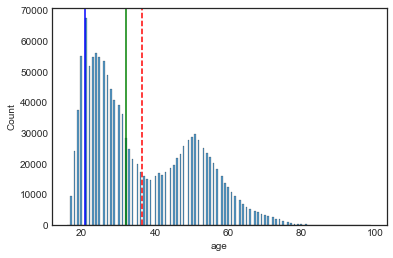

In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')

sns.histplot(data = clean_cust, x = clean_cust.age)

plt.axvline(x = clean_cust.age.mean(), color = 'red', linestyle='--', label="Mean")
plt.axvline(x = clean_cust.age.median(), color='green', linestyle='-', label="Median")
plt.axvline(x = clean_cust.age.mode()[0], color='blue', linestyle='-', label="Mode")


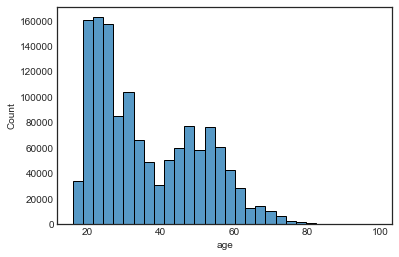

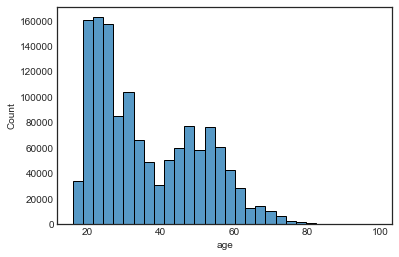

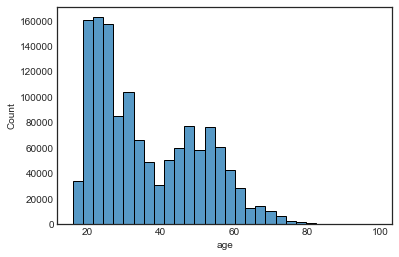

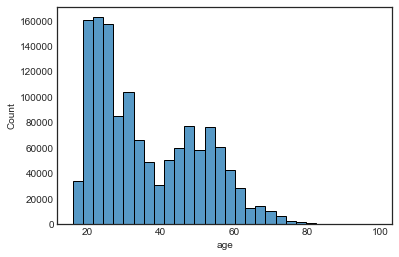

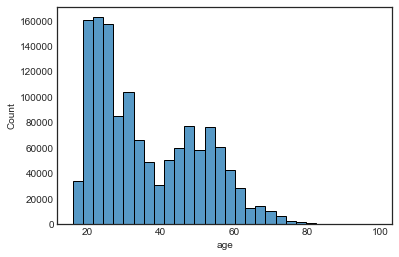

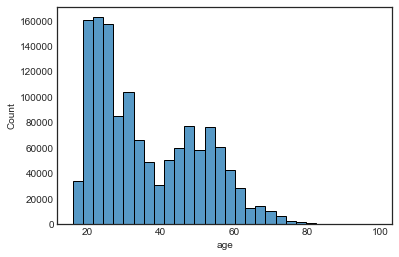

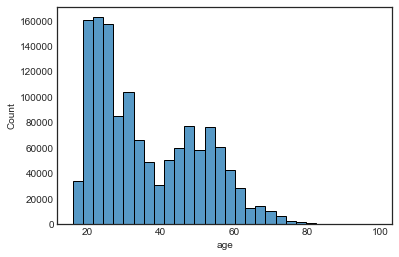

In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')

for i, col in enumerate(clean_cust.columns):
    plt.figure(i)
    sns.histplot(data = clean_cust, x = clean_cust.age, bins = 30)

In [ ]:
articles.head()

In [ ]:
txs.head()

# Exploring the Data

## Building a dataset

We'll start by grouping customers based on certain characteristics.  Some of these could include:
- total spend
- number of items purchased 
- types of items purchased
- demographics (postal code, age, fn status, club membership) 

From there we can start taking <a href=https://www.investopedia.com/ask/answers/032615/what-are-some-examples-stratified-random-sampling.aspstratified> stratified samples </a> or begin <a href=https://en.wikipedia.org/wiki/Cluster_analysis> analyzing clusters </a> where patterns of purchases may emerge.  Since we need to build the model on a subset of the data, we need to ensure that we can capture a representative sample while avoiding overfitting.

In [ ]:
# how many unique customers are in the training dataset? 
len(set(txs['customer_id']))

In [ ]:
# is it equivalent to the number of customers in the customers dataset?
len(clean_cust)

In [ ]:
clean_cust['age'].describe().round(2)

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
clean_cust = customers.copy()
clean_cust['FN'] = customers['FN']
sns.histplot(data=c_customers,x='age',hue='FN', alpha=.3, bins=20)

The customer age follows a bimodal distribution, concentrating around 25 years old and 55 years old, it seems that older customers are more likely to be FN subscribers.

In [ ]:
# take a 10% customer sample from transactions
r_state = 10

sample_10 = clean_cust.sample(frac=.1,random_state = r_state) # take 10% random sample of customer ids
dask_10 = txs[txs['customer_id'].isin(sample_10['customer_id'])].compute() # filter the dataset to just sampled customers

In [ ]:
print(articles.columns)

name_filter = [word for word in articles.columns if 'name' in word] # list comprehension (the cool way)

# test_names = [] # regular way (not as cool)
# for word in articles.columns:
#     if 'name' in word:
#         test_names.append(word)
# test_nanes

# find the count of unique values for each column in articles dataframe

article_names = articles[name_filter].copy()

for col in article_names:
    print(col, article_names[col].nunique())
    
articles[['product_code','prod_name']].nunique()

colors = [word for word in name_filter if 'colour' in word]

articles[colors].head()

It looks like product code and name might be a messy column to use, for example there is a value `Strap Top` as well as `Strap Top (1)` which share the same product code, however there are about 1500 more unique product codes vs names.  It would therefore add more noise to our model than useful information to try and wrangle that, when the combination of other columns as well as unique article ID would be sufficient. We can now drop product name from our filter. 

In [ ]:
dask_10.groupby(['customer_id']).count()

In [ ]:
# classifying a single customers's purchases
cust_1 = dask_10[dask_10['customer_id'] == 'ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264'].copy()

training_cols = ['article_id','price','product_code','product_type_no','graphical_appearance_no',
                'colour_group_code','perceived_colour_value_id','perceived_colour_master_id','department_no',
                'index_code','index_group_no','section_no','garment_group_no']

combined = cust_1.merge(articles,on="article_id")
combined.columns